# 598RL HW4

In [1]:
#import basic packages
from IPython.display import clear_output
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import gridworld

params_ = {}
env = gym.make('GridWorld-v0')

### Set level to  the "easy" version of grid_world (actions deterministically move the agent) or the "hard" version (some probability of moving in a direction different to the desired action)

In [ ]:
set_level = 'easy'

## Common functions:

In [2]:
def get_state_row(curr_state, gridmap):
    
    state_row = curr_state[0]*len(gridmap[0]) + curr_state[1]
    return state_row

## SARSA and Q-Learning functions:

In [3]:
def get_action_Q(Q_table, curr_state, exp_prob, action_str, gridmap):
    
    n_act = len(action_str)
    rand_n = np.random.rand(1)[0]
    if rand_n < exp_prob:
        action = action_str[np.random.randint(n_act)]
        
    else:
        state_row = get_state_row(curr_state, gridmap)
        action_col = np.argmax(Q_table[state_row,:])
        action = action_str[action_col]
        
    return action

In [4]:
def SARSA(params):

    n_eps, episode_length = params['n_eps'], params['episode_length']
    epsilon = params['epsilon']
    epsilon_decay = params['epsilon_decay']
    lr = params['lr']
    gamma = params['gamma']

    n_action = len(env.action_str)
    n_states = len(env.GRIDMAP[0]) * len(env.GRIDMAP)
    Q_ = np.random.rand(n_states,n_action)
    
    reward_array = np.zeros([n_eps,])

    for i_eps in range(0, n_eps):

        eps_reward = 0
        epsilon = epsilon*epsilon_decay
        s = env.reset(set_level)
        a = get_action_Q(Q_, s, epsilon, env.action_str, env.GRIDMAP)

        for i_step in range(0, episode_length):

            srow = get_state_row(s, env.GRIDMAP)
            acol = env.action_str.find(a)

            s_, reward, done, info = env.step(a)
            a_ = get_action_Q(Q_, s_, epsilon, env.action_str, env.GRIDMAP)
            s_row = get_state_row(s_, env.GRIDMAP)
            a_col = env.action_str.find(a_)
            Q_[srow,acol] = Q_[srow,acol] + lr*( reward + gamma*Q_[s_row,a_col] - Q_[srow,acol] )

            eps_reward += reward
            s, a = s_, a_

        reward_array[i_eps] = eps_reward

    return np.arange(n_eps), reward_array, Q_

In [5]:
def QLearning(params):

    n_eps, episode_length = params['n_eps'], params['episode_length']
    epsilon = params['epsilon']
    epsilon_decay = params['epsilon_decay']
    lr = params['lr']
    gamma = params['gamma']
    
    n_action = len(env.action_str)
    n_states = len(env.GRIDMAP[0]) * len(env.GRIDMAP)
    Q_ = np.random.rand(n_states,n_action)

    reward_array = np.zeros([n_eps,])

    for i_eps in range(0, n_eps):

        eps_reward = 0
        epsilon = epsilon*epsilon_decay
        s = env.reset(set_level)

        for i_step in range(0, episode_length):

            srow = get_state_row(s, env.GRIDMAP)

            a = get_action_Q(Q_, s, epsilon, env.action_str, env.GRIDMAP)
            acol = env.action_str.find(a)
            s_, reward, done, info = env.step(a)
            s_row = get_state_row(s_, env.GRIDMAP)

            Q_[srow,acol] = Q_[srow,acol] + lr*( reward + gamma*max(Q_[s_row,:]) - Q_[srow,acol] )

            eps_reward += reward
            s = s_

        reward_array[i_eps] = eps_reward

    return np.arange(n_eps), reward_array, Q_

## REINFORCE functions:

In [6]:
def REINFORCE_get_action(s, policy):
    
    policy_a = np.exp(policy[s,:]) / np.sum(np.exp(policy[s,:]), axis=0)
    #print(policy_a)
    a = np.random.choice(np.arange(policy.shape[1]), 1, replace=False, p=policy_a)
    
    return int(a)

In [7]:
def REINFORCE_get_trajectory(T, policy):
    
    states, actions, rewards = np.zeros([T], dtype=int), np.zeros([T], dtype=int), np.zeros([T], dtype=int)
    
    s = env.reset(set_level)
    states[0] = get_state_row(s, env.GRIDMAP)
    
    for t in range(T):
        #print(states[t])
        
        actions[t] = REINFORCE_get_action(states[t], policy)
        s, rewards[t], _, _ = env.step(env.action_str[actions[t]])
        
        if t!=T-1:
            states[t+1] = get_state_row(s, env.GRIDMAP)
    
    return states, actions, rewards

### Equations to calculate gradient of tabular policy (From lecture notes L4):
<img src="tabular_policy_gradient.jpg">

In [8]:
def REINFORCE_get_gradient(s, a, policy):
    
    dJ = np.zeros(policy.shape)
    policy_a = np.exp(policy[s,:]) / np.sum(np.exp(policy[s,:]), axis=0)
    
    dJ[s,:] = -policy_a[a]
    dJ[s,a] = 1 - policy_a[a]
    
    return dJ

## Train REINFORCE (S&B 13.3):

In [9]:
def policy_gradient(params):

    n_action = len(env.action_str)
    n_states = len(env.GRIDMAP[0]) * len(env.GRIDMAP)

    n_eps, episode_length = params['n_eps'], params['episode_length']
    batch_size = params['batch_size']
    lr = params['lr']

    n_batches = int( n_eps / batch_size)
    policy_ = np.ones((n_states,n_action))
    reward_array = []

    for batch in range(n_batches):

        J_grad = np.zeros(policy_.shape)
        reward_avg = 0
        for n in range(batch_size):

            s, a, r =  REINFORCE_get_trajectory(episode_length, policy_)

            J_curr_traj = np.zeros(policy_.shape)
            reward_curr_traj = 0
            for t in range(episode_length):
                #update the gradient
                J_curr_traj += REINFORCE_get_gradient(s[t], a[t], policy_)
                reward_curr_traj += r[t]

            J_grad += (J_curr_traj * reward_curr_traj) / batch_size

            reward_avg += reward_curr_traj / batch_size

        #update policy
        reward_array.append(reward_avg)
        policy_ = policy_ + lr * J_grad

    return np.arange(n_batches)*batch_size, reward_array, policy_

### Compare policy gradient using different hyperparameters

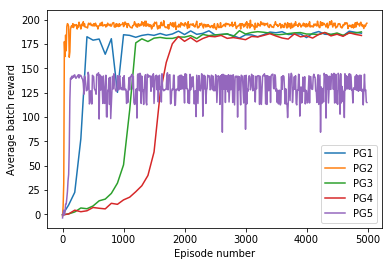

In [20]:
params_.update({'n_eps': 5000, 'episode_length': 100, 'batch_size': 100, 'lr': 0.05})
pg1_x, pg1_y, policy1 = policy_gradient(params_)
params_.update({'n_eps': 5000, 'episode_length': 100, 'batch_size': 10, 'lr': 0.05})
pg2_x, pg2_y, policy2 = policy_gradient(params_)
params_.update({'n_eps': 5000, 'episode_length': 100, 'batch_size': 100, 'lr': 0.01})
pg3_x, pg3_y, policy3 = policy_gradient(params_)
params_.update({'n_eps': 5000, 'episode_length': 100, 'batch_size': 100, 'lr': 0.006})
pg4_x, pg4_y, policy4 = policy_gradient(params_)
params_.update({'n_eps': 5000, 'episode_length': 100, 'batch_size': 10, 'lr': 0.01})
pg5_x, pg5_y, policy5 = policy_gradient(params_)
plt.plot(pg1_x, pg1_y, label='PG1')
plt.plot(pg2_x, pg2_y, label='PG2')
plt.plot(pg3_x, pg3_y, label='PG3')
plt.plot(pg4_x, pg4_y, label='PG4')
plt.plot(pg5_x, pg5_y, label='PG5')
plt.xlabel('Episode number')
plt.ylabel('Average batch reward')
plt.legend()
plt.show()

### Assign best policy for later comparisons

In [21]:
pgb_x, pgb_y, best_policy = pg2_x, pg2_y, policy2

## Train SARSA and Q-Learning (S&B 6.4 and S&B 6.5)

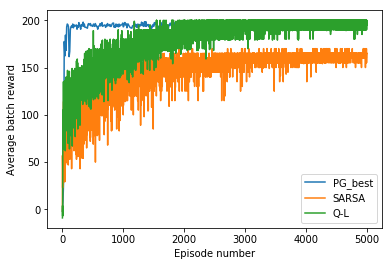

In [22]:
params_.update({'n_eps': 5000, 'episode_length': 100, 'epsilon': 0.4, 'epsilon_decay': 0.999, 'lr': 0.5, 'gamma': 0.99})
sarsa_x, sarsa_y, Q_sarsa = SARSA(params_)
params_.update({'n_eps': 5000, 'episode_length': 100, 'epsilon': 0.4, 'epsilon_decay': 0.999, 'lr': 1.0, 'gamma': 0.99})
ql_x, ql_y, Q_ql = QLearning(params_)
plt.plot(pgb_x, pgb_y, label='PG_best')
plt.plot(sarsa_x, sarsa_y, label='SARSA')
plt.plot(ql_x, ql_y, label='Q-L')
plt.xlabel('Episode number')
plt.ylabel('Average batch reward')
plt.legend()
plt.show()

## Visualize trajectory

In [23]:
#visualize trajectory:
mode = 'policy_gradient'
# mode = 'SARSA'
# mode = 'Q_learning'

episode_length = 20
reward_total = 0
sleep_time = 0.5
s = env.reset(set_level)
clear_output(wait=True)
env.render()
time.sleep(sleep_time)

for i_step in range(0, episode_length):

    if mode is 'policy_gradient':
        a = env.action_str[REINFORCE_get_action(get_state_row(s, env.GRIDMAP), best_policy)]
    elif mode is 'SARSA':
        a = get_action(Q_sarsa, s, 0.0, env.action_str, env.GRIDMAP)
    elif mode is 'Q_learning':
        a = get_action(Q_ql, s, 0.0, env.action_str, env.GRIDMAP)

    s, reward, done, info = env.step(a)
    reward_total += reward
    clear_output(wait=True)
    env.render()
    print('\nStep:',i_step, 'Reward:', reward_total)
    time.sleep(sleep_time)

-X-B-
-----
---b-
-----
-a---

Step: 19 Reward: 40
